# RTML FINAL EXAM | Chanapa Pananookooln (st121395)
## Question 6, 30 points

Based on your existing DQN implementation, implement the double DQN and self-play training method
you just described. After some training (don't spend too much time on training -- again, we just want to see that the model can
learn), show the result you playing a game against your learned agent.

In [1]:
import math, random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device
device = "cpu"

In [2]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

# Epsilon annealing schedule generator
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [3]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=n_state, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=n_action))
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.Tensor(state).unsqueeze(0)).to(device)
#             print(state.shape)
            q_value = self.forward(state)
            q_value = q_value.cpu()
#             print(q_value.shape)
            action = q_value.max(1)[1].item()            
        else: # get random action
#             action = random.randrange(env.action_space.n)
            action = random.randrange(9)
        return action
    
    def get_q_value(self, state):
        state = autograd.Variable(torch.Tensor(state).unsqueeze(0)).to(device)
#             print(state.shape)
        q_value = self.forward(state)
        q_value = q_value.cpu()
#             print(q_value.shape)
        action = q_value.max(1)[1].item() 
        
        return q_value, action
        

In [5]:
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.Tensor(np.float32(state)).to(device)
    next_state = torch.Tensor(np.float32(next_state)).to(device)
    action     = torch.Tensor(action).long().to(device)
    reward     = torch.Tensor(reward).to(device)
    done       = torch.Tensor(done).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [6]:
def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = obs.reshape(27)
#     state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done = env.step(action)
        next_state = next_obs.reshape(27)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = obs.reshape(27)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: # update target_model weight. The '500' is hyperparameter, you can change it as you want
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

In [7]:
import math, random
import importlib
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np
import os

from collections import deque
from tqdm import trange
from games.abstract_game import AbstractGame

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name) 

env = game_module.Game()

current_model = DQN(27, 9).to(device)
target_model = DQN(27, 9).to(device)
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [8]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

Agent training (episode50001) Avg Reward 0.15959680806383872: 100%|██████████| 50001/50001 [02:23<00:00, 348.23it/s]  


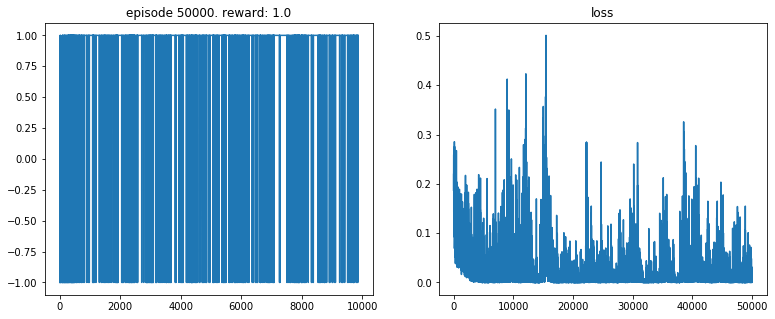

In [9]:
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)
torch.save(current_model.state_dict(), 'weights/tictactoe-final-HW-SO-SAD.pth')

# RL vs ME

In [12]:
def play_game_with_me(model):
    player = 1
    done = False
    state = env.reset()
    state = state.reshape(27)
    
    while(not done):
        if env.to_play() == player:
            available_action = env.legal_actions()
            print("available action:", available_action)
            action = env.human_to_action()

            next_state, reward, done = env.step(action)
            next_state = next_state.reshape(27)
            print("HOOMAN agent")
            print(env.action_to_string(action))
        else:
            action = model.act(state, epsilon_final)
            next_state, reward, is_done = env.step(action)
            next_state = next_state.reshape(27)
            print("DOUBLE DQN MODEL PLAY")
            print(env.action_to_string(action))
        env.render()
        time.sleep(0.03)
        state = next_state

In [13]:
current_model.load_state_dict(torch.load('weights/tictactoe-final-HW-SO-SAD.pth', map_location=torch.device('cpu') ))

play_game_with_me(current_model)

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]


Enter the row (1, 2 or 3) to play for the player 1:  2
Enter the column (1, 2 or 3) to play for the player 1:  2


HOOMAN agent
Play row 2, column 2
   |   |   
---+---+---
   | O |   
---+---+---
   |   |   
DOUBLE DQN MODEL PLAY
Play row 2, column 3
   |   |   
---+---+---
   | O | X 
---+---+---
   |   |   
available action: [0, 1, 2, 3, 6, 7, 8]


Enter the row (1, 2 or 3) to play for the player 1:  3
Enter the column (1, 2 or 3) to play for the player 1:  1


HOOMAN agent
Play row 3, column 1
   |   |   
---+---+---
   | O | X 
---+---+---
 O |   |   
DOUBLE DQN MODEL PLAY
Play row 2, column 1
   |   |   
---+---+---
 X | O | X 
---+---+---
 O |   |   
available action: [0, 1, 2, 7, 8]


Enter the row (1, 2 or 3) to play for the player 1:  1
Enter the column (1, 2 or 3) to play for the player 1:  3


HOOMAN agent
Play row 1, column 3
   |   | O 
---+---+---
 X | O | X 
---+---+---
 O |   |   


# Sadly I won against my model ...